In [1]:
!pip3 install pytrends
!pip3 install pyupbit
!pip3 install pyjwt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16126 sha256=f3406a31ed4622849686c458d5be05d91ebdca0f6c91f94fa5e6b1cc326cacab
  Stored in directory: /root/.cache/pip/wheels/07/6f/5c/8174f98dec1bfbc7d5da4092854afcbcff4b26c3d9b66b5183
Successfully built pytrends
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 21.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pytrends.request import TrendReq
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# connect to google 

from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360) 

# build payload

kw_list = ["bitcoin","Ethereum"] # list of keywords to get data 

pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y') 

#1 Interest over Time
data = pytrends.interest_over_time() 
data = data.reset_index() 


import plotly.express as px

fig = px.line(data, x="date", y=['bitcoin','Ethereum'], title='Keyword Web Search Interest Over Time')
fig.show() 

# pytrends.get_historical_interest(kw_list, year_start=2021, month_start=9, day_start=1, hour_start=0, year_end=2021, month_end=9, day_end=30, hour_end=0, cat=0, sleep=0)

In [5]:
data['date'] = data.date.dt.date
print(data.dtypes)
print(data)
google_df = data

date         object
bitcoin       int64
Ethereum      int64
isPartial      bool
dtype: object
           date  bitcoin  Ethereum  isPartial
0    2017-11-19       27         4      False
1    2017-11-26       60         6      False
2    2017-12-03       83         7      False
3    2017-12-10       84         9      False
4    2017-12-17      100         8      False
..          ...      ...       ...        ...
255  2022-10-09       14         3      False
256  2022-10-16       12         2      False
257  2022-10-23       14         3      False
258  2022-10-30       14         3      False
259  2022-11-06       24         4       True

[260 rows x 4 columns]


In [7]:
import pyupbit
print(pyupbit.get_tickers(fiat="USDT"))

['USDT-BTC', 'USDT-ETH', 'USDT-XRP', 'USDT-ETC', 'USDT-OMG', 'USDT-ADA', 'USDT-TUSD', 'USDT-SC', 'USDT-TRX', 'USDT-BCH', 'USDT-DGB', 'USDT-DOGE', 'USDT-ZRX', 'USDT-RVN', 'USDT-BAT']


In [14]:
df1 = pyupbit.get_ohlcv(ticker="USDT-BTC", interval='day', count=1825, to=None, period= 1)
df2 = pyupbit.get_ohlcv(ticker="USDT-ETH", interval='day', count=1825, to=None, period= 1)

def get_rsi(df, period = 14):
  df["close"] = df["close"]
  delta = df['close'].diff()
  up, down = delta.copy(), delta.copy()
  # 상승분, U
  up[up < 0 ] = 0

  #하락분, D
  down[down > 0] = 0
  
  # AU (U값의 평균)
  _gain = up.ewm(com=(period - 1), min_periods=period).mean()
  
  #DU (D값의 평균)
  _loss = down.abs().ewm(com=(period - 1), min_periods=period).mean()

  RS = _gain/_loss
  rsi_14 = pd.Series(100 - (100 / (1 + RS)), name = "RSI")
  df['rsi']=rsi_14
  return df

df1= get_rsi(df1)
df2= get_rsi(df2)

In [15]:
print(df1)
print()
print(df2)

                             open          high           low         close  \
2017-11-16 09:00:00   7250.000000   7965.000000   7003.082481   7860.000000   
2017-11-17 09:00:00   7867.900000   7995.000000   7453.100000   7670.010000   
2017-11-18 09:00:00   7670.010000   7880.000000   7379.100000   7790.000000   
2017-11-19 09:00:00   7790.000000   8138.795284   7649.449999   8065.000000   
2017-11-20 09:00:00   8065.000000   8330.000000   7960.000000   8239.000000   
...                           ...           ...           ...           ...   
2022-11-10 09:00:00  15537.944000  18155.544000  15537.944000  17724.070000   
2022-11-11 09:00:00  17724.070000  17995.688288  16016.876058  17574.795814   
2022-11-12 09:00:00  17574.795814  17858.147000  14503.000000  16796.000000   
2022-11-13 09:00:00  16793.770000  17299.134617  16071.050554  16570.000000   
2022-11-14 09:00:00  16570.000000  16916.104669  15850.000000  16366.292135   

                           volume         value    

In [23]:
# # df1 = pd.DataFrame(df1, columns = ['USDT-BTC'])
# df1 = pd.DataFrame(df1['close'])
# df1.columns = ['USDT-BTC']
# df2 = pd.DataFrame(df2['close'])
# df2.columns = ['USDT-ETH']
# upbit_df = pd.concat([df1,df2], axis=1)
# upbit_df.reset_index(inplace=True)
# upbit_df.rename(columns = {'index':'date'}, inplace=True)
# upbit_df['date'] = upbit_df.date.dt.date
# print(upbit_df)
df3 = pd.DataFrame(df1['rsi'])
df3.columns = ["rsi"]
df3.reset_index(inplace = True)
df3.rename(columns = {"index":"date"}, inplace = True)
df3['date'] = df3.date.dt.date
outer_df = pd.merge(google_df, df3, how = "outer", on = "date")
dropna_df = outer_df.dropna()
print(dropna_df)

           date  bitcoin  Ethereum isPartial        rsi
2    2017-12-03     83.0       7.0     False  88.970806
3    2017-12-10     84.0       9.0     False  76.554297
4    2017-12-17    100.0       8.0     False  80.389629
5    2017-12-24     62.0       5.0     False  45.975377
6    2017-12-31     45.0       7.0     False  47.695759
..          ...      ...       ...       ...        ...
255  2022-10-09     14.0       3.0     False  45.390237
256  2022-10-16     12.0       2.0     False  47.780062
257  2022-10-23     14.0       3.0     False  53.705149
258  2022-10-30     14.0       3.0     False  62.174085
259  2022-11-06     24.0       4.0      True  61.588546

[258 rows x 5 columns]


In [26]:
import plotly.express as px

fig = px.line(dropna_df, x='date', y=['bitcoin','rsi'], title='Result')
fig.show() 

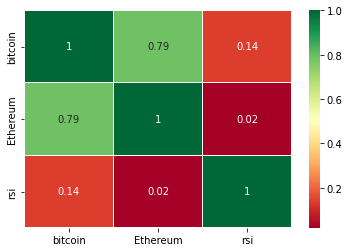

In [27]:
import seaborn as sns

sns.heatmap(dropna_df.corr(),linewidths=0.1, cmap='RdYlGn', linecolor='white', annot=True)

In [9]:
outer_df = pd.merge(google_df, upbit_df, how="outer", on="date")

In [10]:
print(outer_df)

            date  bitcoin  Ethereum isPartial      USDT-BTC     USDT-ETH
0     2017-11-19     27.0       4.0     False   8065.000000   355.610000
1     2017-11-26     60.0       6.0     False   9190.888900   466.000000
2     2017-12-03     83.0       7.0     False  11205.000000   461.930000
3     2017-12-10     84.0       9.0     False  14977.000000   431.000000
4     2017-12-17    100.0       8.0     False  18917.000000   704.759417
...          ...      ...       ...       ...           ...          ...
1845  2022-11-10      NaN       NaN       NaN  17724.070000  1286.591287
1846  2022-11-11      NaN       NaN       NaN  17574.795814  1279.599120
1847  2022-11-12      NaN       NaN       NaN  16796.000000  1245.861704
1848  2022-11-13      NaN       NaN       NaN  16570.000000  1369.698631
1849  2022-11-14      NaN       NaN       NaN  16478.276000  1368.918118

[1850 rows x 6 columns]


In [11]:
dropna_df = outer_df.dropna()
print(dropna_df)

           date  bitcoin  Ethereum isPartial      USDT-BTC     USDT-ETH
0    2017-11-19     27.0       4.0     False   8065.000000   355.610000
1    2017-11-26     60.0       6.0     False   9190.888900   466.000000
2    2017-12-03     83.0       7.0     False  11205.000000   461.930000
3    2017-12-10     84.0       9.0     False  14977.000000   431.000000
4    2017-12-17    100.0       8.0     False  18917.000000   704.759417
..          ...      ...       ...       ...           ...          ...
255  2022-10-09     14.0       3.0     False  19324.102716  1316.344488
256  2022-10-16     12.0       2.0     False  19345.579956  1310.442294
257  2022-10-23     14.0       3.0     False  19651.617398  1357.371175
258  2022-10-30     14.0       3.0     False  20641.907716  1588.582711
259  2022-11-06     24.0       4.0      True  20993.085018  1573.080000

[255 rows x 6 columns]


In [13]:
import plotly.express as px

fig = px.line(dropna_df, x="date", y=['bitcoin','Ethereum','USDT-BTC','USDT-ETH'], title='Result')
fig.show() 

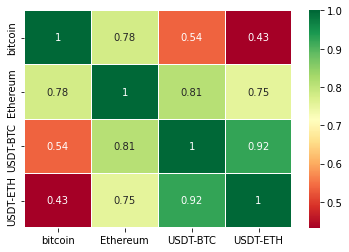

In [12]:
import seaborn as sns

sns.heatmap(dropna_df.corr(),linewidths=0.1, cmap='RdYlGn', linecolor='white', annot=True)